In [1]:
input_dim = 4
num_clusters = 3
num_classes = 3

model_file = "/home/gregory/Desktop/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt"

import csv
import json
import numpy as np
import os
import pandas as pd


import sys
sys.path.insert(0, "../Code/")
from explain_cs import explain
from load_scvis import load_vae
from metrics import metrics, eval_epsilon
from myplot import plot_polys, plot_groups, plot_metrics, plot_explanation
from misc import poly2labels

def load_model(input_dim = input_dim, model_file = model_file):
    return load_vae(input_dim, model_file)


In [2]:
# Load Data & Configuration

x = pd.read_csv("Data/X.tsv", sep="\t").values

y = pd.read_csv("Data/y.tsv", sep="\t").values


with open("vertices.json") as json_file:  
    all_vertices = json.load(json_file)


In [3]:
# Calculate Data Representation

sess, rep, X, D = load_model()

data_rep = sess.run(rep, feed_dict={X: x, D: np.zeros((1, input_dim))})

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


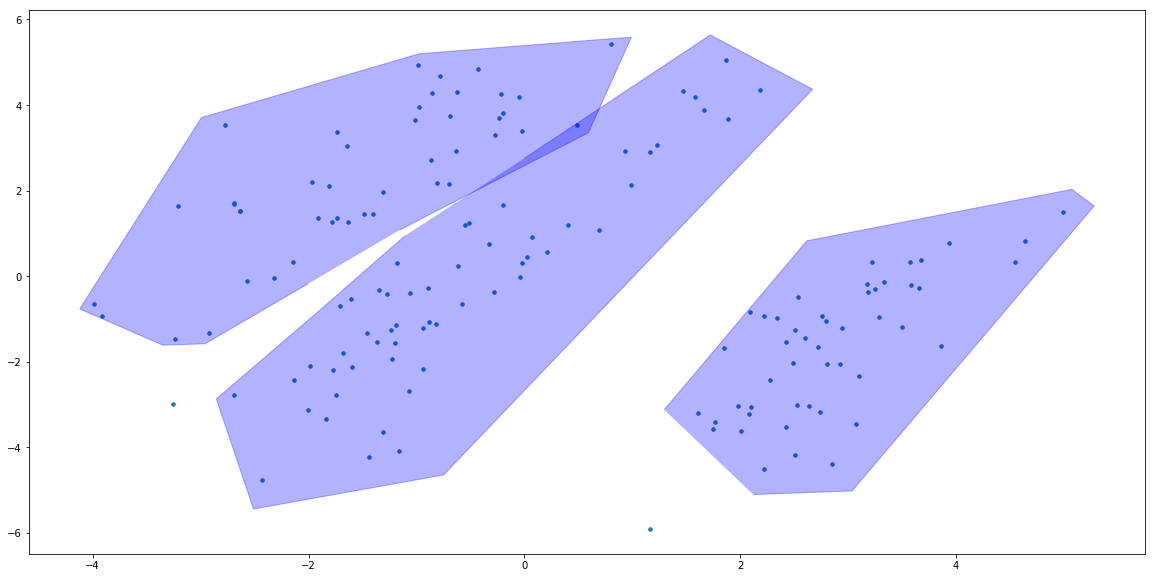

In [4]:
# Visualize the data and the marked clusters

plot_polys(data_rep, all_vertices)

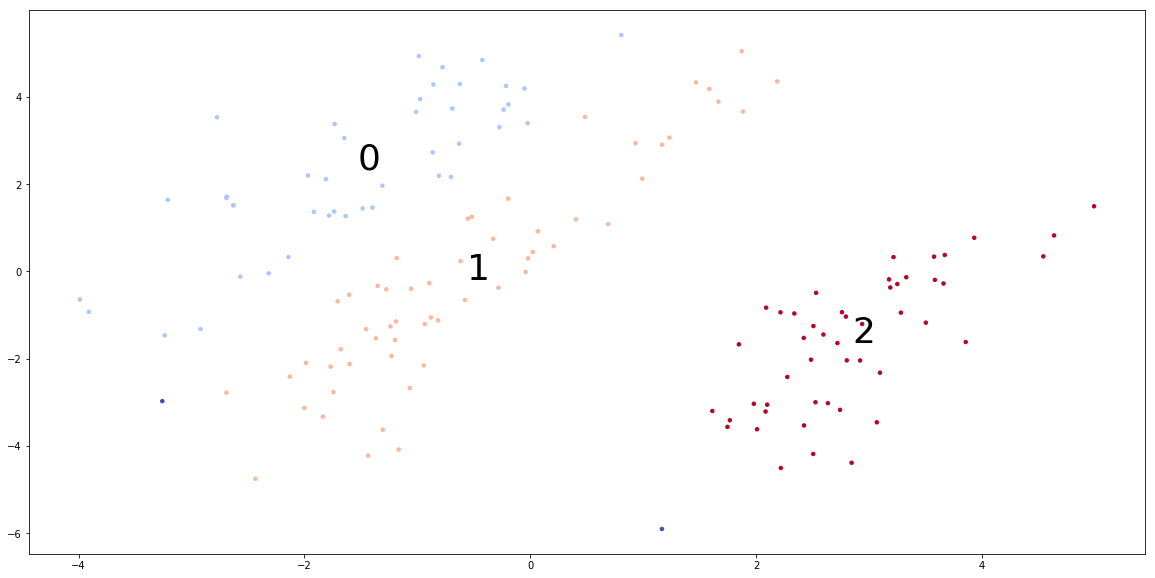

In [ ]:
# Visualize the clusters in the learned representation

labels = poly2labels(data_rep, all_vertices)

means, centers, indices = plot_groups(x, data_rep, num_clusters, labels, name = "iris-rep.png")


In [ ]:
# Inspect the correlation between cluster and class

confusion  = np.zeros((num_clusters, num_classes))
for i in range(y.shape[0]):
    if labels[i] != -1.0:
        confusion[int(labels[i]), int(y[i])] += 1
    
print(confusion)

[[ 0.  5. 38.]
 [ 0. 44. 12.]
 [48.  0.  0.]]


In [ ]:
# Set epsilon for our metrics

epsilon = 0.75

if True:
    eval_epsilon(load_model, x, indices, epsilon)


INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


In [ ]:
# Compute the group explanations

best_val = 0.0
for i in range(5):
    deltas = explain(load_model, means, centers, learning_rate = 0.01, consecutive_steps = 5, lambda_global = 2.5)
    a, b = metrics(load_model, x, indices, deltas, epsilon)
    
    val = np.mean(a)
    
    if val > best_val:
        best_val = val
        np.save("deltas.npy", deltas)
    
    os.system("rm -rf explanation")

                    

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Iris/Model/model/perplexity_10_regularizer_0.001_batch_size_149_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


In [ ]:
# Evaluate the explanations

deltas = np.load("deltas.npy")

a, b = metrics(load_model, x, indices, deltas, epsilon)

plot_metrics(a, b, name = "iris-metrics.png")


In [ ]:
# Visualize the group explanations

plot_explanation(load_model, x, data_rep, indices, deltas, a, b, 0, 1, name = "iris-0to1.png", num_points = 20)

plot_explanation(load_model, x, data_rep, indices, deltas, a, b, 0, 2, name = "iris-0to2.png", num_points = 20)

plot_explanation(load_model, x, data_rep, indices, deltas, a, b, 1, 2, name = "iris-1to2.png", num_points = 20)


In [ ]:
# Group 0 is Iris Virginica, Group 1 is Iris Versicolour, and Group 2 is Iris Setosa
# The main separating factor is feature 3 (petal width): 0 -> 2 has a large decrease while 0 -> 1 has a small increase
# That results is consistent with the decision tree from here:  https://sebastianraschka.com/Articles/2014_intro_supervised_learning.html